<a href="https://colab.research.google.com/github/Joa1Camargo/Analise-de-Dados/blob/main/Risco_de_Credito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Risco de Crédito
Instituições financeiras investem uma grande quantidade de dinheiro na construção de modelos de análise de risco de crédito para determinar a probabilidade de inadimplência de um potencial tomador de empréstimo. Esses modelos fornecem informações sobre o nível de risco de crédito de um tomador em qualquer momento específico.

Vamos começar com a definição de “crédito”:

“Crédito é a capacidade de tomar dinheiro emprestado ou acessar bens ou serviços com o entendimento de que você pagará depois.”

“Credibilidade de crédito (creditworthiness) é como um credor determina se você irá inadimplir suas obrigações de dívida, ou quão apto você é para receber um novo crédito. Sua credibilidade de crédito é o que os credores analisam antes de aprovar qualquer novo crédito para você.”

O risco de crédito é uma área financeira geralmente relacionada a hipotecas, cartões de crédito e outros tipos de empréstimos. Sempre existe a probabilidade de que o devedor não devolva o valor emprestado. Tradicionalmente, isso se refere ao risco de que o credor não receba o principal e os juros devidos, o que resulta em interrupção dos fluxos de caixa e aumento dos custos de cobrança.

Portanto, avaliar e gerenciar adequadamente o risco de crédito pode reduzir a gravidade de uma perda.

Agenda:

Assim, é importante que, quando um tomador solicita um empréstimo, o credor ou emissor estabeleça e avalie a capacidade do tomador de reembolsar o empréstimo. Portanto, neste notebook, farei o seguinte:

1. Exploração do conjunto de dados (EDA)

2. Aplicação do KNN SMOTE como técnica de oversampling

3. Teste de modelos de machine learning com boosting usando a técnica de validação cruzada

4. Ajuste de hiperparâmetros para obter o melhor modelo e construção do pipeline

5. Avaliação do melhor modelo com a ajuda de métricas relevantes

6. Serialização (pickling) do melhor pipeline - Escolha do modelo e download



---


Para carregar dados do Google Drive, primeiro você precisa montá-lo. Isso permitirá que o Colab acesse seus arquivos.

Depois que o Drive for montado, você poderá especificar o caminho para seu arquivo CSV e carregá-lo em um DataFrame do pandas.

In [24]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
!pip install catboost

In [76]:
pip install scikit-learn

In [95]:
## Basic Libraries:
import pandas as pd
pd.options.display.max_colwidth=150   ## this is used to set the column width.

## Note: Other available must know options are:
# pd.options.display.max_rows=x  ## controls the max rows to be displayed on screen
# pd.options.display.max_columns=x  ## controls the max columns to be displayed on screen
# pd.options.display.precision=x  ## controls the precision of each floating points to be displayed on screen
# pd.options.display.float_format = '{:.2f}%'.format  ## controls the format of displaying numbers on screen.
                                                      ## For eg.{$(:,.2f)} can be used for currency

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

plt.style.use('fivethirtyeight') ## Setting the Style

## For making sample data:
from sklearn.datasets import make_classification

## For Preprocessing:
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, RepeatedKFold,RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# from sklearn.base import TransformerMixin,BaseEstimator

## Using imblearn library:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

## Using msno Library for Missing Value analysis:
import missingno as msno

## For Metrics:
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import learning_curve

## For Machine Learning Models:
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

## For Pickling:
import pickle

In [27]:
import sklearn
sklearn.__version__

'1.6.1'

In [28]:
## Setting the seed to allow reproducibility
np.random.seed(31415)

# Exploratory Data Analysis | Análise Exploratória de Dados

In [29]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/Risco de Crédito/credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [30]:
sample= df.sample(10000).reset_index(drop=True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [32]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [33]:
duplicados=df.duplicated()
duplicados.value_counts()

,count
False,32416
True,165


In [34]:
print(f"Shape dos dados antes de remover duplicados -----> ({df.shape[0]},{df.shape[1]}) \n")
df.drop_duplicates(inplace=True)
print(f"Shape dos dados depois de remover duplicados  -----> ({df.shape[0]},{df.shape[1]})")

Shape dos dados antes de remover duplicados -----> (32581,12) 

Shape dos dados depois de remover duplicados  -----> (32416,12)


In [35]:
ccol=df.select_dtypes(include=["object"]).columns
ncol=df.select_dtypes(include=["int","float"]).columns

print("Quantidade de colunas categóricas:",len(ccol))
print("Quantidade de colunas numéricas",len(ncol))

Quantidade de colunas categóricas: 4
Quantidade de colunas numéricas 8


In [36]:
print("Vou fazer uma análise da quatidade de valores únicos nas colunas numéricas e categóricas")
print("As colunas numéricas são:\n")
for i in ncol:
    print("->",i,"-",df[i].nunique())

print("\n---------------------------\n")
print("As colunas categóricas são:\n")
for i in ccol:
    print("->",i,"-",df[i].nunique())

Vou fazer uma análise da quatidade de valores únicos nas colunas numéricas e categóricas
As colunas numéricas são:

-> person_age - 58
-> person_income - 4295
-> person_emp_length - 36
-> loan_amnt - 753
-> loan_int_rate - 348
-> loan_status - 2
-> loan_percent_income - 77
-> cb_person_cred_hist_length - 29

---------------------------

As colunas categóricas são:

-> person_home_ownership - 4
-> loan_intent - 6
-> loan_grade - 7
-> cb_person_default_on_file - 2


"loan_int_rate" represneta a taxa de juros oferecida pelas instituições financeiras. Como varia de banco pra banco, será removida.

In [37]:
df.drop(['loan_int_rate'],axis=1,inplace=True)

Analisando as variáveis categóricas:

In [38]:
df["loan_intent"].unique()

array(['PERSONAL', 'EDUCATION', 'MEDICAL', 'VENTURE', 'HOMEIMPROVEMENT',
       'DEBTCONSOLIDATION'], dtype=object)

In [39]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_status', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length'],
      dtype='object')

Analisando a variável alvo: 'loan_status' (Status de empréstimo)

In [40]:
df["loan_status"].value_counts(normalize=True)

,proportion
loan_status,
0,0.781312
1,0.218688


Os dados estão altamente desbalanceados. Vou usar técnicas de amostragem como KNN-SMOTE para lidar com isso.


---

# Análise de dados ausentes

Dados ausentes ocorrem quanto não temos o dado para certas variáveis ou participantes. Eles podem estar incompletos por erros de equipamento, arquivos perdidos, entradas incompletas e etc.

Os dados ausentes são problematicos pq podem causar bias de amostragem. Isso significa que seus resultados podem não ser generalizaveis fora do da sua amostra, pq seu dado não é representativo

In [41]:
df.isnull().any()

,0
person_age,False
person_income,False
person_home_ownership,False
person_emp_length,True
loan_intent,False
loan_grade,False
loan_amnt,False
loan_status,False
loan_percent_income,False
cb_person_default_on_file,False


In [42]:
df.isna().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,887
loan_intent,0
loan_grade,0
loan_amnt,0
loan_status,0
loan_percent_income,0
cb_person_default_on_file,0


Agora vou utilizar a bilbioteca missingno pra analisar os dados ausentes.

No Grafico de barras temos:


*   Eixo Y esquerdo: Quantos % temos de completude dos dados (de 0 a 1)
*   Eixo Y direito: Total de linhas do DF.
*   Eixo X inferior: Colunas do dataframe
*   Eixo X superior: quantidade de dados completos naquela coluna.





<Axes: >

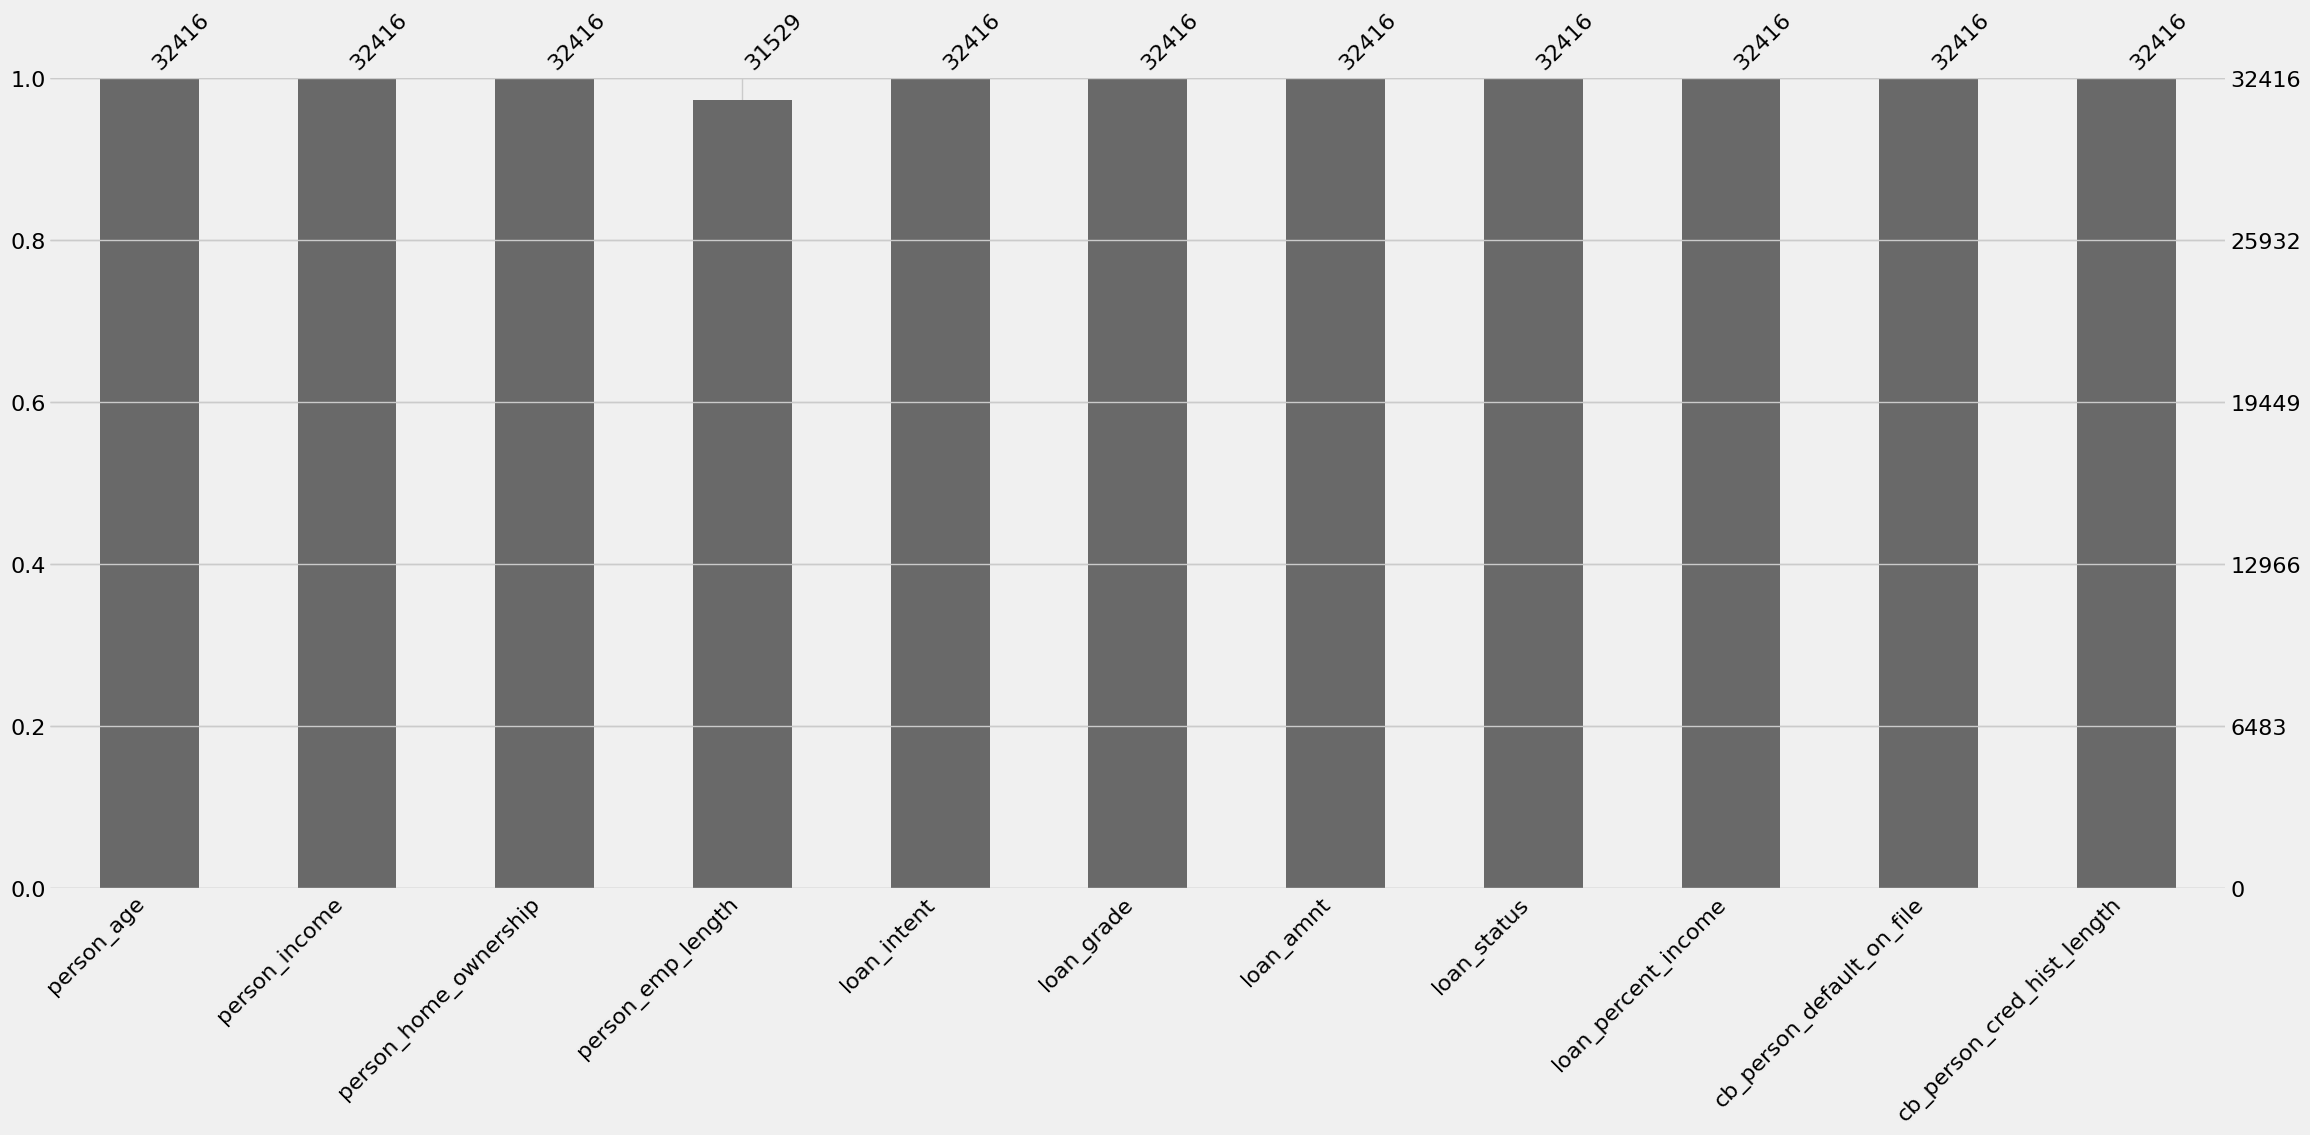

In [43]:
msno.bar(df)

Na matriz, os dados ausentes são representados por linhas brancas na coluna.

<Axes: >

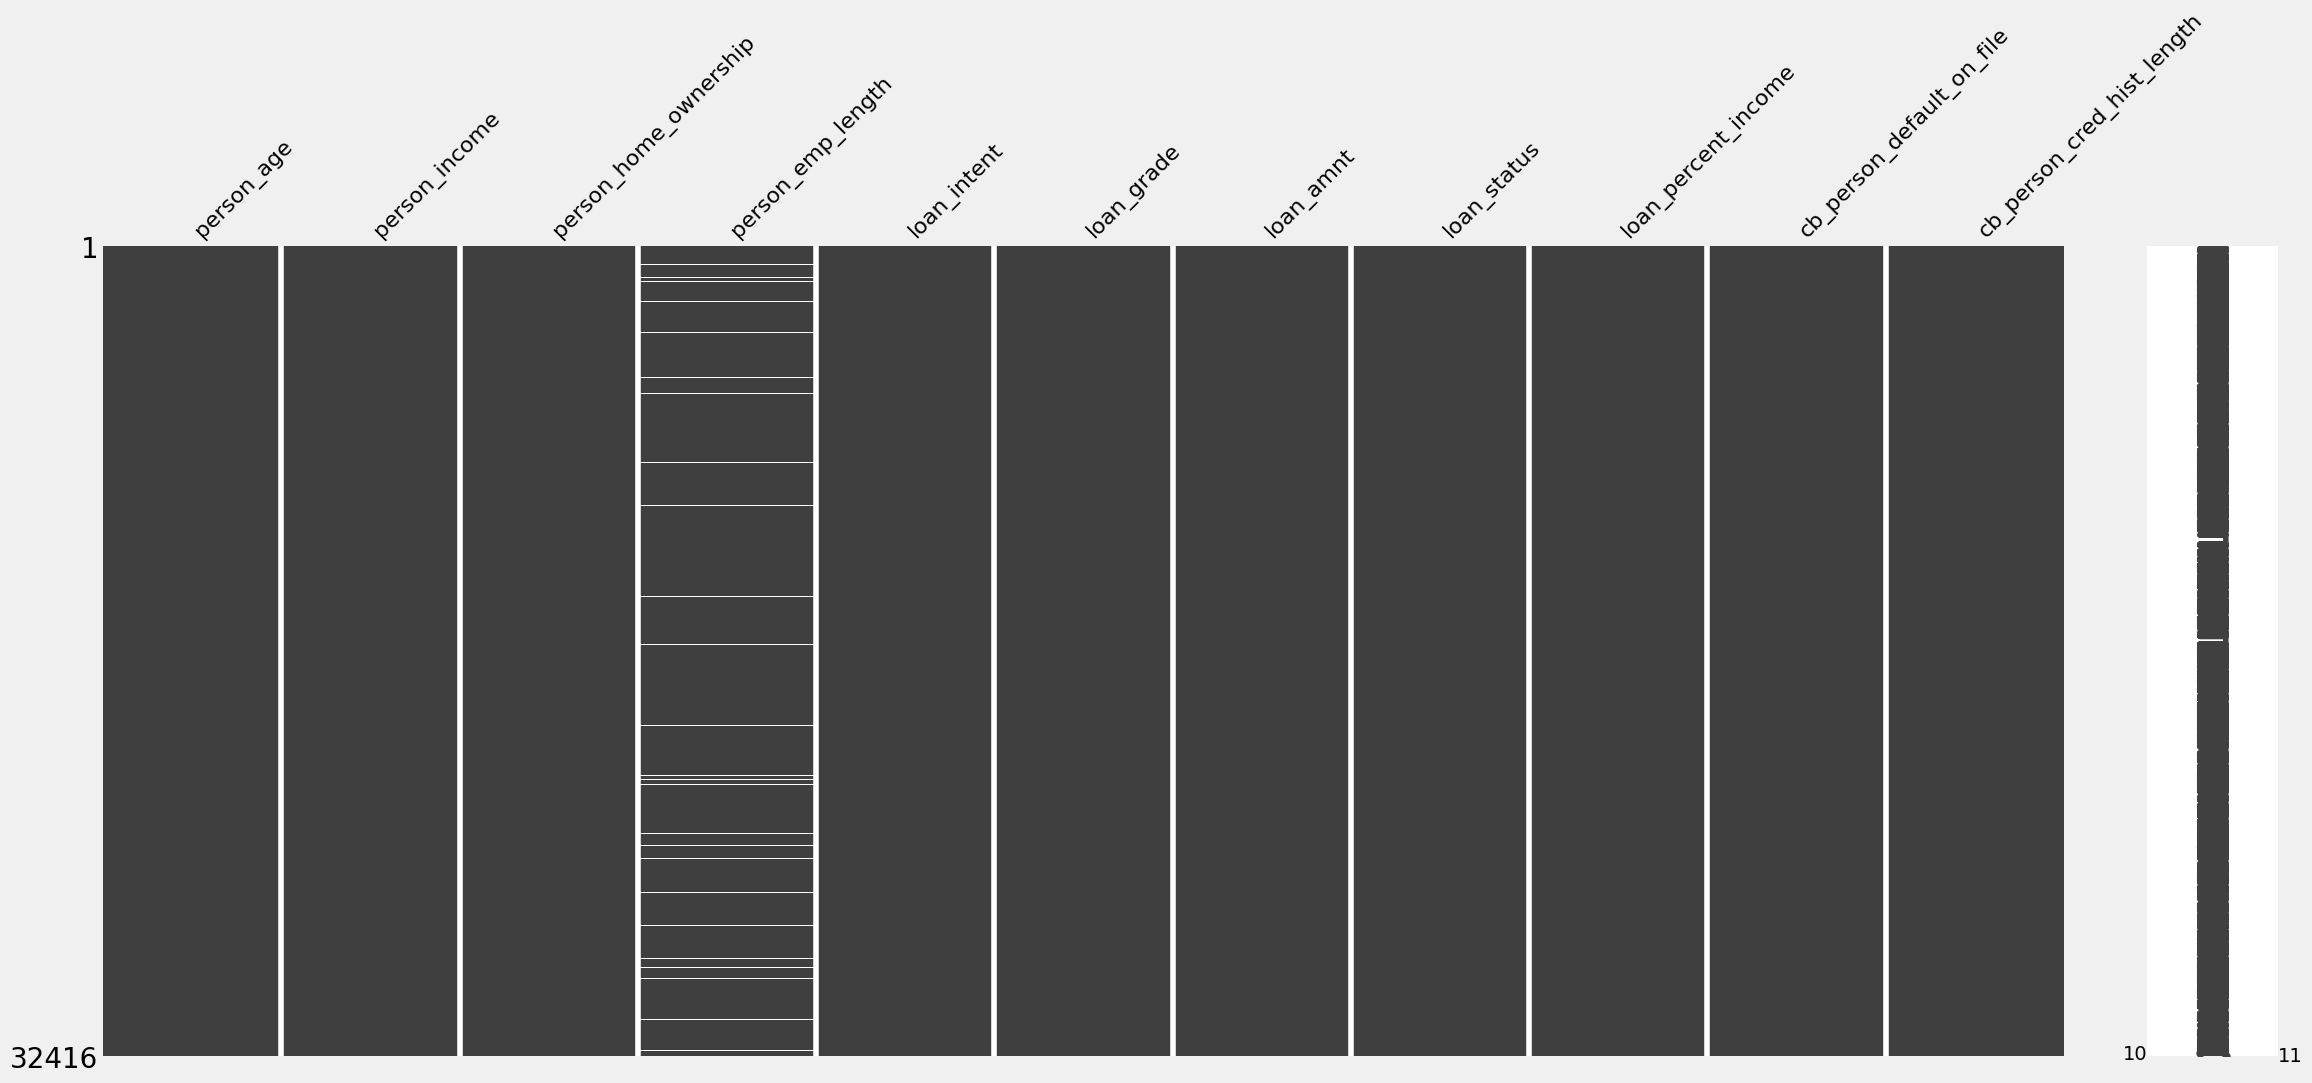

In [44]:
msno.matrix(df)

O heatmap mostra correlação entre os dados de cada coluna, se não houver correlação (como é o caso), o grafico ficara em branco.

<Axes: >

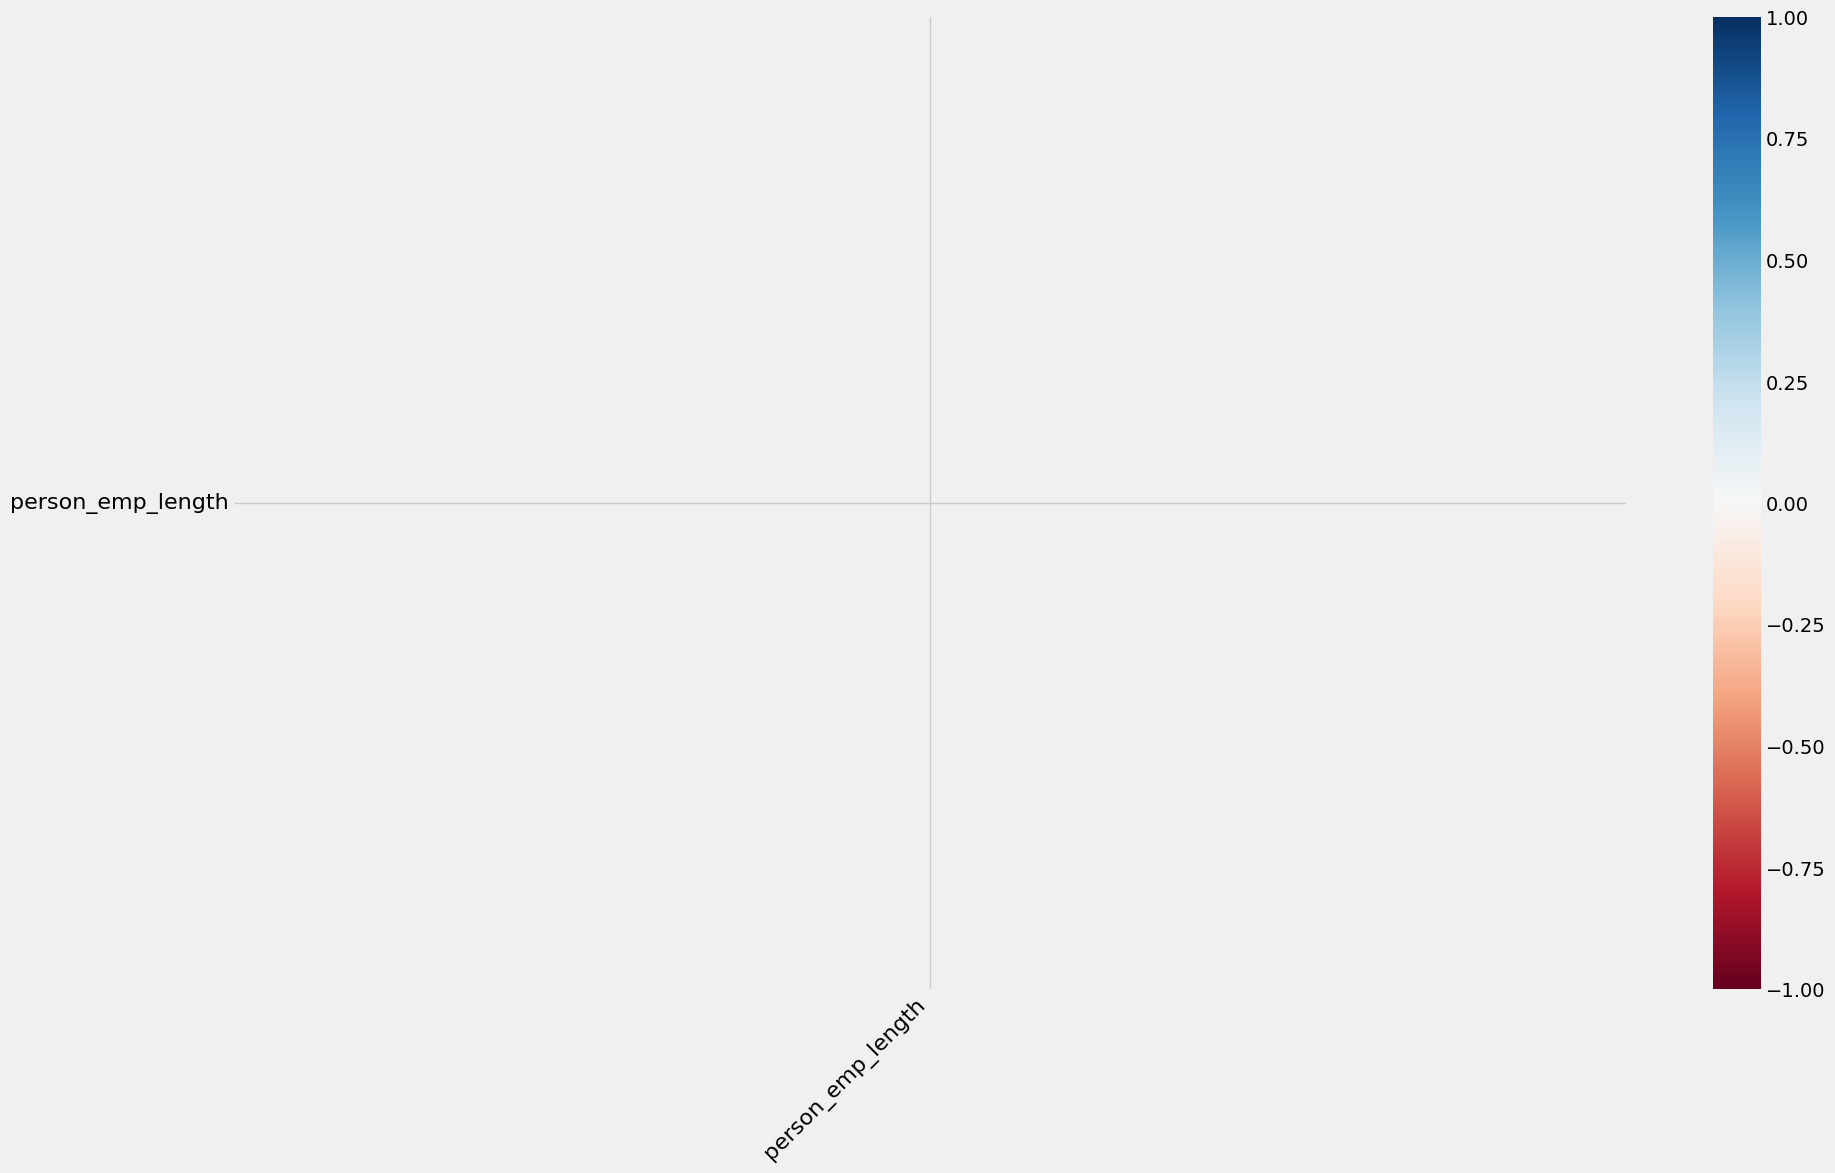

In [45]:
msno.heatmap(df)

O dendrograma (arvore inversa) mostra a relação doa quanto uma coluna de dados prevê a completude da coluna.

<Axes: >

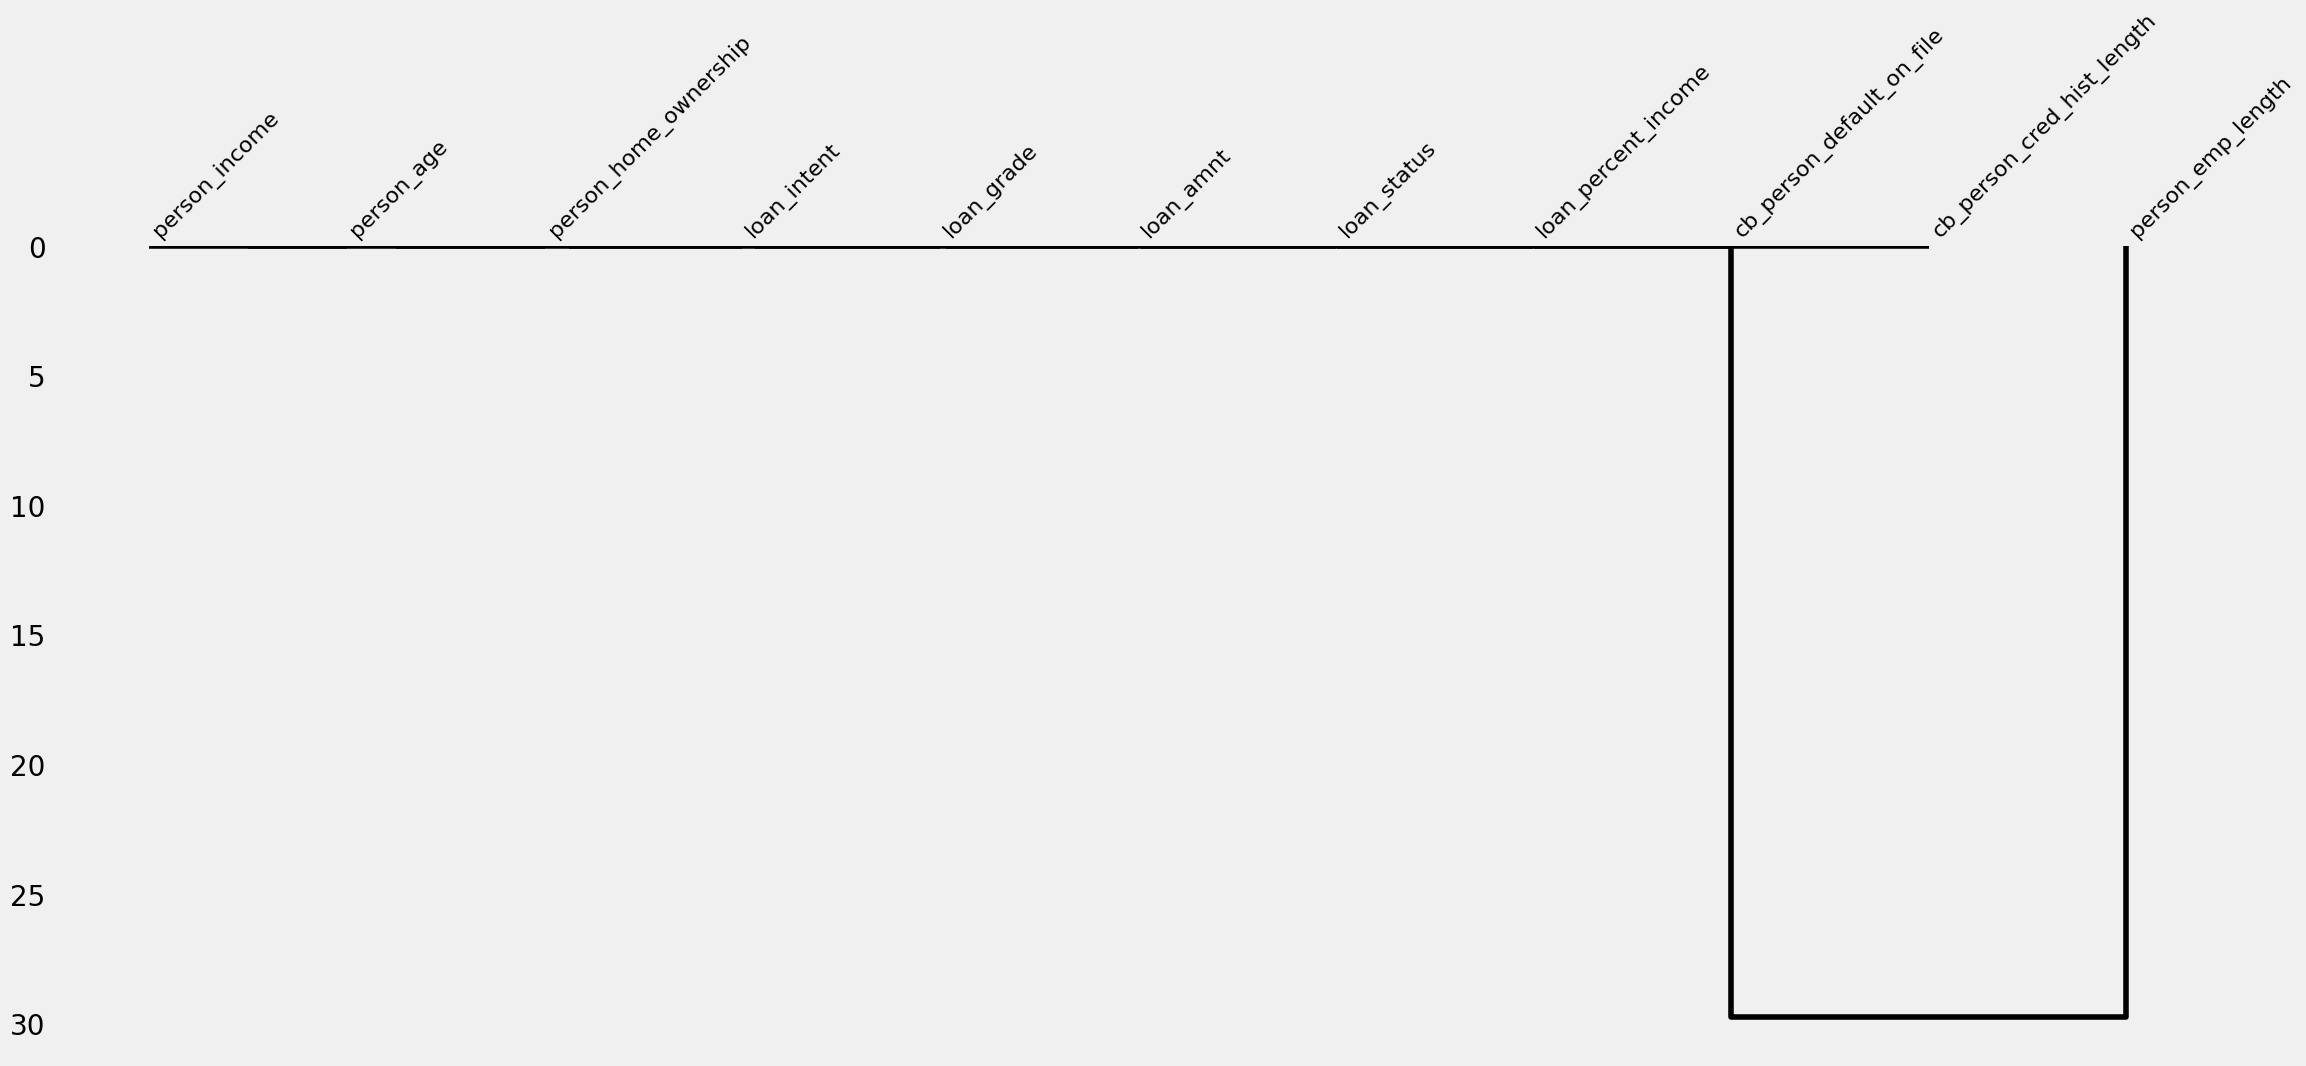

In [47]:
msno.dendrogram(df)

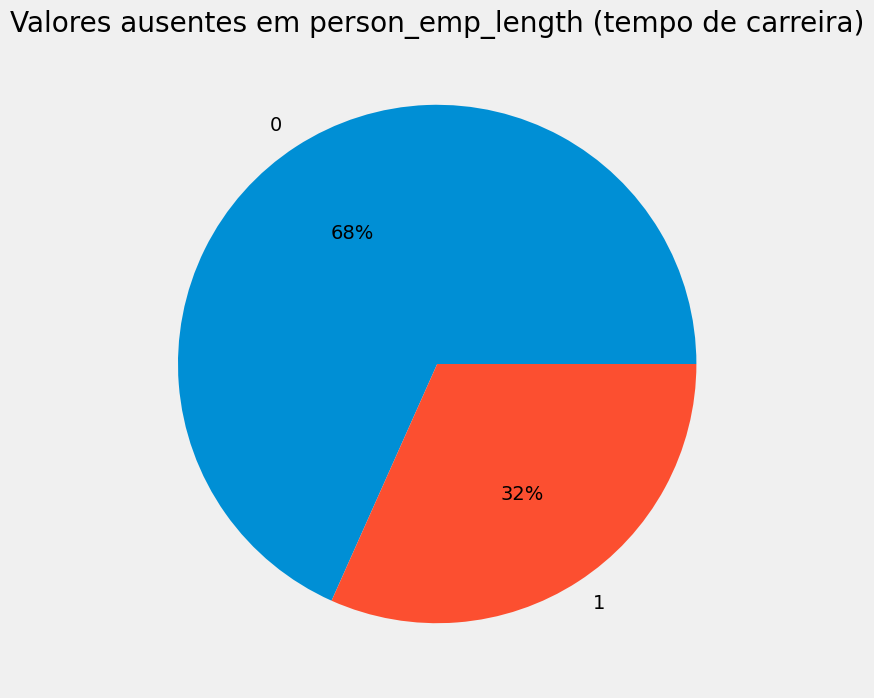

In [48]:
## Valores ausentes nas variaveis alvo:
p=df.groupby(["loan_status"])["person_emp_length"].apply(lambda x:x.isnull().sum())

fig,ax=plt.subplots(1,1,figsize=(8,8))

ax.set_title("Valores ausentes em person_emp_length (tempo de carreira)")
ax.pie(p.values, labels=p.index, autopct='%.0f%%')
fig.show()

Pronto, agora vou lidar com os valores ausentes aqui: Primeiro vou separar os dados em dados de teste e dados de treino

In [50]:
# X e y representam os dados de treino
# X_test e y_test são as amostras pra avaliação de modelo (teste)

X, X_test, y, y_test = train_test_split(df.drop('loan_status', axis=1), df['loan_status'],
                                        random_state=0,  test_size=0.2, stratify=df['loan_status'],
                                        shuffle=True)

In [54]:
# Checando a proporção do modelo:
print(y.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

loan_status
0    0.781313
1    0.218687
Name: proportion, dtype: float64
loan_status
0    0.781308
1    0.218692
Name: proportion, dtype: float64


,proportion
loan_status,
0,0.781308
1,0.218692


In [55]:
#Checando valores ausentes nos dados de treino:
(X.shape[0]-X.dropna().shape[0])/X.shape[0]*100

2.799629801018047

Agora vou checar os outliers e remover eles dos dados. Existem várias formas pra tratar os outliers, seja estatisticamente ou então removendo alguns dados indesejados. Nesse dataset, alguns dados não fazem sentido (por erro de entrada, provavelmente) então vou remover eles.

<Axes: >

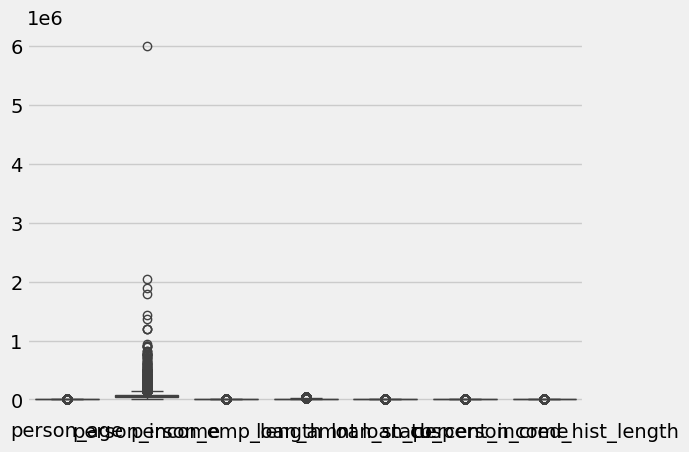

In [57]:
sns.boxplot(df)


Vamos visualizar os outliers das colunas `person_age` e `person_emp_length` separadamente para uma melhor análise.

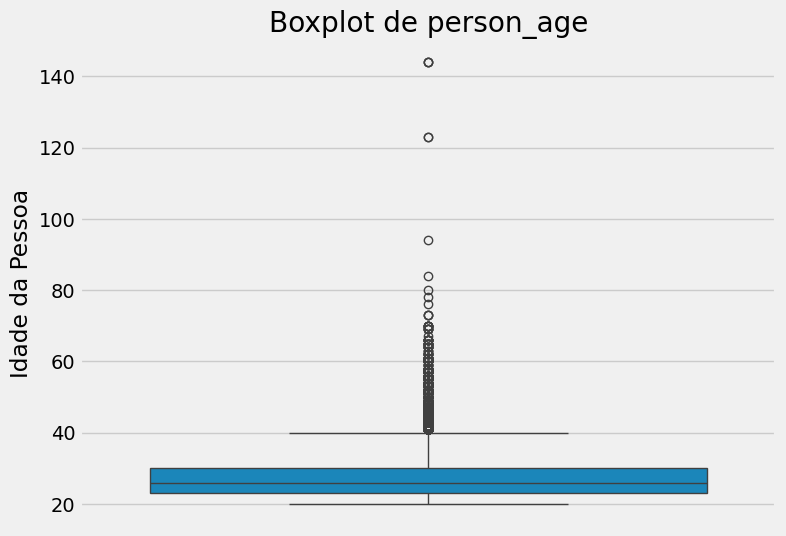

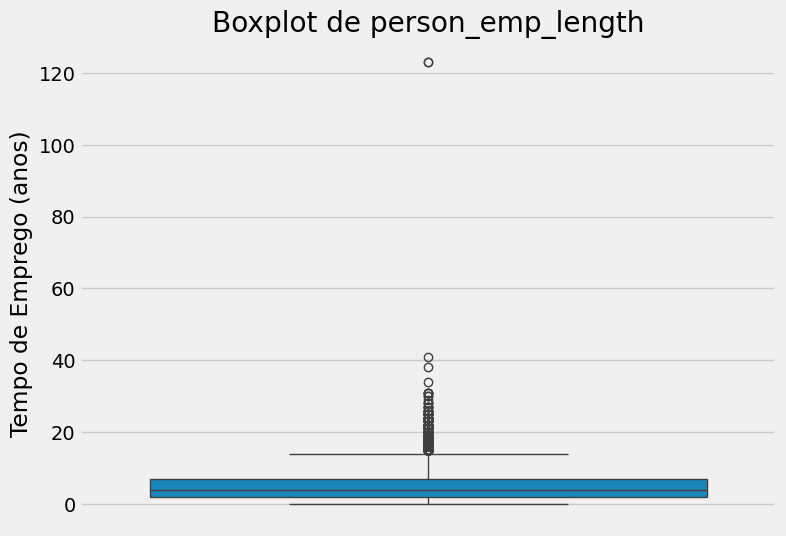

In [58]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['person_age'])
plt.title('Boxplot de person_age')
plt.ylabel('Idade da Pessoa')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(y=df['person_emp_length'])
plt.title('Boxplot de person_emp_length')
plt.ylabel('Tempo de Emprego (anos)')
plt.show()

O Pipeline Principal será composto por duas partes:

**Pré-processamento para VARIÁVEIS NUMÉRICAS:**
* Imputador Iterativo - Para lidar com valores ausentes
* Escalonamento - Para manter a escala entre as características

**Pré-processamento para VARIÁVEIS CATEGÓRICAS:**
* One Hot Encoder - Para codificar cada categoria para interpretabilidade do modelo

Finalmente, aplicamos:
* SMOTE - Para lidar com o desbalanceamento no conjunto de dados

Podemos ver que temos dados impraticaveis aqui: idades e carreiras superiores a 100 anos (até 140) o que é impraticavel.

In [59]:
X.loc[X['person_age']>=80, :]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
32422,80,64000,RENT,7.0,MEDICAL,B,6800,0.11,N,25
81,144,250000,RENT,4.0,VENTURE,C,4800,0.02,N,3
32416,94,24000,RENT,1.0,MEDICAL,C,6500,0.27,N,27
747,123,78000,RENT,7.0,VENTURE,B,20000,0.26,N,4
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,0.03,N,2
575,123,80004,RENT,2.0,EDUCATION,B,20400,0.25,N,3
32506,84,94800,MORTGAGE,2.0,PERSONAL,A,10000,0.11,N,24
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,0.00,N,25


In [60]:
X.loc[X['person_emp_length']>=60, :]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,0.10,N,4
0,22,59000,RENT,123.0,PERSONAL,D,35000,0.59,Y,3


In [61]:
#Removendo os outliers
X = X.loc[X['person_age']<80, :]
X = X.loc[X['person_emp_length']<60, :]

In [62]:
#passando a remocão para y de treino
y = y[X.index]

In [63]:
y.value_counts()

,count
loan_status,
0,19744
1,5452


---
# 2. Criando o Melhor Pipeline de Dados

O Pipeline será composto por duas partes:
Pré-processamento para
**VARIÁVEIS NUMÉRICAS**:

- Imputador iterativo – para lidar com valores ausentes
- Escalonamento – para manter a escala entre as características

Pré-processamento para **VARIÁVEIS CATEGÓRICAS:**

- Codificador One Hot – para codificar cada categoria visando a interpretabilidade do modelo

- Por fim, o SMOTE – para lidar com o desequilíbrio no conjunto de dados

In [65]:
## Pipeline:

### 1. Criando pipeline pras variaveis numericas:
num_pipe = Pipeline([
    ('impute', IterativeImputer()),     #MICE (Multivariate Imputation by Chained Equations)
    ('scale', StandardScaler()),
])

### 2. Utilização da classe Column Transformer para vincular o pipeline numérico acima e as etapas de pré-processamento das colunas categóricas:
### Aqui, para manter uma lista das colunas numéricas e categóricas, utilizei o método make_column_selector. Você pode ler mais sobre ele aqui: https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html

ct = ColumnTransformer([
    ('num_pipe', num_pipe, make_column_selector(dtype_include=np.number)),
    ('cat_cols', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=object))
], remainder='passthrough')


## Configurando os modelos a serem testados e os parâmetros para seus pipelines:

grid = {
    XGBClassifier():
    {'model__n_estimators':[i*100 for i in range(10)],
     'model__max_depth':[6,8,10,12,14,16],
     'model__learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
     'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0), #coltf é o nome do pipeline final
                                        KNeighborsRegressor()]},                                      #A base do estimador de
                                                                                                #imputacao iterativa tbm é considerado
    LGBMClassifier(class_weight='balanced', random_state=0):                                          # como um parametro
    {'model__n_estimators':[300,400,500],
     'model__learning_rate':[0.001,0.01,0.1,1,10],
     'model__boosting_type': ['gbdt', 'goss', 'dart'],
     'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]}

}

In [66]:
for i,(clf, param) in enumerate(grid.items()):
    print(f"{i+1}. {clf}")
    print(f"\nLista de Hyperparameters: {param}")
    print('-'*50)

1. XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Lista de Hyperparameters: {'model__n_estimators': [0, 100, 200, 300, 400, 500, 600, 700, 800, 900], 'model__max_depth': [6, 8, 10, 12, 14, 16], 'model__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3], 'coltf__num_pipe__impute__estima

In [67]:
%%time
full_df = pd.DataFrame()
best_algos = {}

## Mudando a ordem das colunas para melhor entendimento:
X=X[X.select_dtypes(include=[np.number]).columns.append(X.select_dtypes("O").columns)]

for model, param in grid.items():
    ## O SMOTE:
    smt = SMOTE(random_state=42)

    pipe = Pipeline([
    ('coltf', ct),     #ct para o colum transformer de preprocessamento
    ('smote', smt),
    ('model', model)
])
    print(f"Training {model}!!\n")
    ## Realizando uma Busca Aleatória (Randomized Search) para encontrar os hiperparâmetros ótimos mais adequados
    gs = RandomizedSearchCV(estimator=pipe, param_distributions=param, scoring='accuracy',verbose=3, n_iter=4, random_state=0)

    print("Ajustando!!\n")
    gs.fit(X, y)

    print("Obtendo resultados!!\n")
    all_res = pd.DataFrame(gs.cv_results_)

    temp = all_res.loc[:, ['params', 'mean_test_score']]
    algo_name = str(model).split('(')[0]
    temp['algo'] = algo_name

    full_df = pd.concat([full_df, temp], ignore_index=True)
    best_algos[algo_name] = gs.best_estimator_

Training XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)!!

Ajustando!!

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END coltf__num_pipe__impute__estimator=RandomForestRegressor(random_state=0), model__learning_rate=0.3, model__max_depth=10, model__n_estimators=

In [68]:
full_df.sort_values('mean_test_score', ascending=False)

,params,mean_test_score,algo
7,"{'model__n_estimators': 300, 'model__learning_rate': 0.1, 'model__boosting_type': 'dart', 'coltf__num_pipe__impute__estimator': KNeighborsRegresso...",0.937649,LGBMClassifier
2,"{'model__n_estimators': 500, 'model__max_depth': 16, 'model__learning_rate': 0.05, 'coltf__num_pipe__impute__estimator': KNeighborsRegressor()}",0.933878,XGBClassifier
1,"{'model__n_estimators': 900, 'model__max_depth': 8, 'model__learning_rate': 0.15, 'coltf__num_pipe__impute__estimator': RandomForestRegressor(rand...",0.933244,XGBClassifier
0,"{'model__n_estimators': 400, 'model__max_depth': 10, 'model__learning_rate': 0.3, 'coltf__num_pipe__impute__estimator': RandomForestRegressor(rand...",0.931775,XGBClassifier
3,"{'model__n_estimators': 300, 'model__max_depth': 14, 'model__learning_rate': 0.01, 'coltf__num_pipe__impute__estimator': KNeighborsRegressor()}",0.930267,XGBClassifier
5,"{'model__n_estimators': 300, 'model__learning_rate': 0.01, 'model__boosting_type': 'dart', 'coltf__num_pipe__impute__estimator': LinearRegression()}",0.919630,LGBMClassifier
6,"{'model__n_estimators': 300, 'model__learning_rate': 0.001, 'model__boosting_type': 'gbdt', 'coltf__num_pipe__impute__estimator': RandomForestRegr...",0.918797,LGBMClassifier
4,"{'model__n_estimators': 300, 'model__learning_rate': 0.001, 'model__boosting_type': 'dart', 'coltf__num_pipe__impute__estimator': KNeighborsRegres...",0.918400,LGBMClassifier


In [69]:
full_df.sort_values('mean_test_score', ascending=False).iloc[0, 0]

{'model__n_estimators': 300,
 'model__learning_rate': 0.1,
 'model__boosting_type': 'dart',
 'coltf__num_pipe__impute__estimator': KNeighborsRegressor()}

In [70]:
## Pegando o pipeline dos melhor XGBoost e do melhor LGB:
be_xgb = best_algos['XGBClassifier']
be_lgb = best_algos['LGBMClassifier']
be_xgb,be_lgb

(Pipeline(steps=[('coltf',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('num_pipe',
                                                   Pipeline(steps=[('impute',
                                                                    IterativeImputer(estimator=KNeighborsRegressor())),
                                                                   ('scale',
                                                                    StandardScaler())]),
                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7fa8d0a6ce90>),
                                                  ('cat_cols',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   <sklearn.compose._...
                                feature_types=None, feature_weights=None,
                                gamma=None, gro

Treinando os melhores pipelines:

A Validação Cruzada k-Fold Repetida oferece uma maneira de aprimorar a estimativa de desempenho de um modelo de aprendizado de máquina. Isso envolve simplesmente repetir o procedimento de validação cruzada várias vezes e reportar o resultado médio de todas as divisões (folds) e execuções. Espera-se que esse resultado médio seja uma estimativa mais precisa do verdadeiro desempenho médio subjacente e desconhecido do modelo no conjunto de dados, calculado por meio do erro padrão.

Vou utilizar essa técnica aqui para testar o desempenho do modelo mais uma vez antes de avaliá-lo.

**-  Treinando o Modelo XGB**

In [71]:
%%time
## Um teste do melhor pipeline:
pipe_xgb = be_xgb
# valiando o pipeline usando o k-fold cross validation:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(pipe_xgb, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"A MÉDIA do score obtido depois da CROSS VALIDATION do Pipeline baseado em XGB é: {scores.mean()} or {scores.mean()*100:.2f}%")

A MÉDIA do score obtido depois da CROSS VALIDATION do Pipeline baseado em XGB é: 0.9337329045088522 or 93.37%
CPU times: user 1.56 s, sys: 282 ms, total: 1.85 s
Wall time: 5min 34s


In [81]:
%%time
## Ajustando no melhor pipeline pra validação:
pipe_xgb.fit(X, y)
## Obtendo as predições:
preds_xgb = pipe_xgb.predict(X_test)
## Obtendo as probabilidades:
probs_xgb = pipe_xgb.predict_proba(X_test)
## Score de Acuracidade:
print(f"O SCORE de ACURACIDADE produzido no SET DE TESTE pelo pipeline XGB é: {accuracy_score(y_test,preds_xgb)} or {accuracy_score(y_test,preds_xgb)*100}%.")

O SCORE de ACURACIDADE produzido no SET DE TESTE pelo pipeline XGB é: 0.9299814929056138 or 92.99814929056139%.
CPU times: user 1min 14s, sys: 288 ms, total: 1min 14s
Wall time: 1min 21s


**- Trainando o modelo LGBM**

In [83]:
%%time
## Um teste do melhor pipeline:
pipe_lgb = be_lgb
# valiando o pipeline usando o k-fold cross validation:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(pipe_lgb, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"A MÉDIA do score obtido depois da CROSS VALIDATION do Pipeline baseado em LGBM é:: {scores.mean()} or {scores.mean()*100:.2f}%")

A MÉDIA do score obtido depois da CROSS VALIDATION do Pipeline baseado em LGBM é:: 0.9378340767411021 or 93.78%
CPU times: user 1.29 s, sys: 218 ms, total: 1.51 s
Wall time: 4min 43s


In [84]:
%%time
## Ajustando no melhor pipeline pra validação
pipe_lgb.fit(X, y)
## Obtendo as predições:
preds_lgb = pipe_lgb.predict(X_test)
## Obtendo as probabilidades:
probs_lgb = pipe_lgb.predict_proba(X_test)
## Score de Acuracidade:
print(f"O SCORE de ACURACIDADE produzido no SET DE TESTE pelo pipeline LGBM é: {accuracy_score(y_test,preds_lgb)} or {accuracy_score(y_test,preds_lgb)*100}%.")

[LightGBM] [Info] Number of positive: 19744, number of negative: 19744
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5678
[LightGBM] [Info] Number of data points in the train set: 39488, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
O SCORE de ACURACIDADE produzido no SET DE TESTE pelo pipeline LGBM é: 0.9336829117828501 or 93.368291178285%.
CPU times: user 19.1 s, sys: 41.1 ms, total: 19.1 s
Wall time: 19.2 s


Checando as probalidades preditas obtidas nos dados de teste

In [85]:
probs_xgb[:10]

array([[9.9949932e-01, 5.0070562e-04],
       [9.0324879e-04, 9.9909675e-01],
       [9.9222624e-01, 7.7737509e-03],
       [9.9908859e-01, 9.1141841e-04],
       [9.9876553e-01, 1.2344521e-03],
       [9.8486388e-01, 1.5136137e-02],
       [9.7011435e-01, 2.9885642e-02],
       [9.9797690e-01, 2.0231274e-03],
       [9.9828440e-01, 1.7156107e-03],
       [9.0774494e-01, 9.2255041e-02]], dtype=float32)

In [86]:
probs_lgb[:10]

array([[0.9771237 , 0.0228763 ],
       [0.01477819, 0.98522181],
       [0.91359079, 0.08640921],
       [0.9529445 , 0.0470555 ],
       [0.89411662, 0.10588338],
       [0.92388957, 0.07611043],
       [0.77961363, 0.22038637],
       [0.94891041, 0.05108959],
       [0.94100427, 0.05899573],
       [0.80564024, 0.19435976]])

- Curva de Aprendizagem (Learning Curve)

A curva de aprendizagem é muito importante para entender se o modelo esta generalisando o suficiente

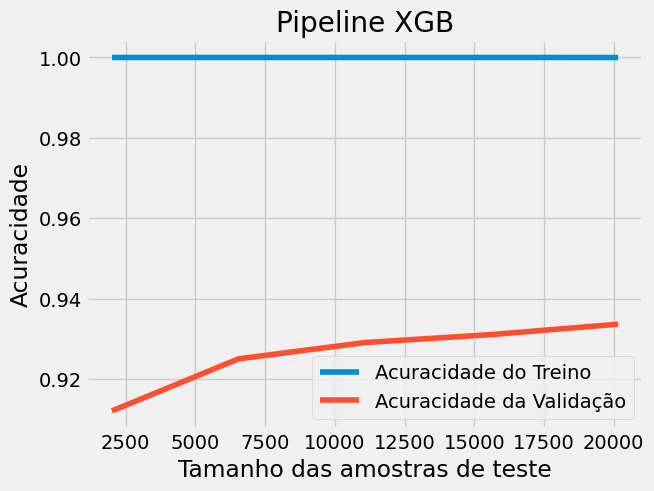

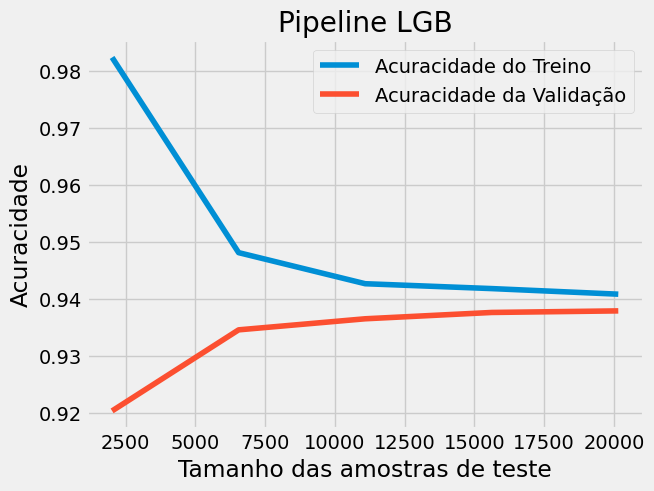

CPU times: user 2.93 s, sys: 434 ms, total: 3.37 s
Wall time: 8min 35s


In [87]:
%%time
def funct_lc(be,X_train,y_train,title):
    a, b, c = learning_curve(be, X_train, y_train, n_jobs=-1, scoring='accuracy')
    plt.title(f"{title}")
    plt.plot(a, b.mean(axis=1), label='Acuracidade do Treino')
    plt.plot(a, c.mean(axis=1),  label='Acuracidade da Validação')
    plt.xlabel('Tamanho das amostras de teste')
    plt.ylabel('Acuracidade')
    plt.legend()
    plt.show()

funct_lc(be_xgb,X,y,"Pipeline XGB")
funct_lc(be_lgb,X,y,"Pipeline LGB")

---
# 3. Avaliando os resultados do melhor modelo

[[4988   78]
 [ 376 1042]]

Matriz de Confusão Pipeline XBG:


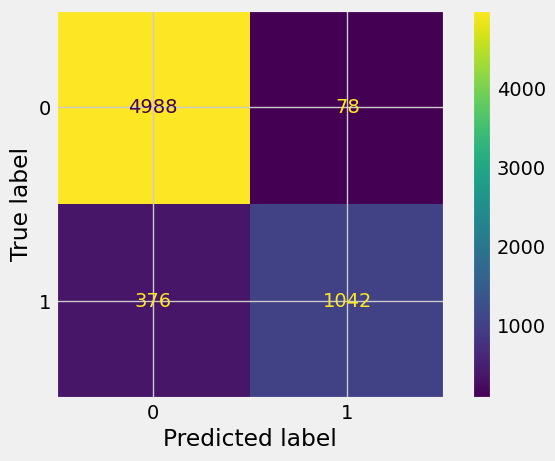


O Reporte de Classificação Pipeline XBG:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      5066
           1       0.93      0.73      0.82      1418

    accuracy                           0.93      6484
   macro avg       0.93      0.86      0.89      6484
weighted avg       0.93      0.93      0.93      6484


O Score Final de acuracidade para o Pipeline XBG: 0.9299814929056138


[[5038   28]
 [ 402 1016]]

Matriz de Confusão Pipeline LGB:


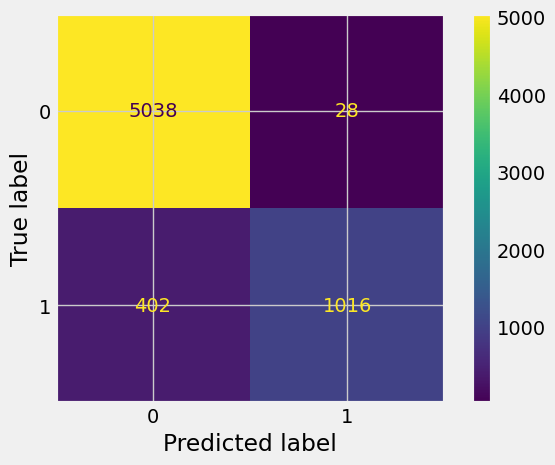


O Reporte de Classificação Pipeline LGB:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5066
           1       0.97      0.72      0.83      1418

    accuracy                           0.93      6484
   macro avg       0.95      0.86      0.89      6484
weighted avg       0.94      0.93      0.93      6484


O Score Final de acuracidade para o Pipeline LGB: 0.9336829117828501




In [91]:
## Function for confusion matrix:
def funct_cm(be,X_test,y_test,preds,title):
    ## Simple Confusion Matrix:
    print(confusion_matrix(y_test, preds))

    print(f"\nMatriz de Confusão {title}:")
    ## Plotting the Confusion Matrix:
    ConfusionMatrixDisplay.from_estimator(be, X_test, y_test)
    plt.show()

    print(f"\nO Reporte de Classificação {title}:")
    ## Classification Report:
    print(classification_report(y_test, preds))

    print(f"\nO Score Final de acuracidade para o {title}: {be.score(X_test, y_test)}")
    ## Accuracy Score
    print("\n")

funct_cm(be_xgb,X_test,y_test,preds_xgb,"Pipeline XBG")
funct_cm(be_lgb,X_test,y_test,preds_lgb,"Pipeline LGB")

In [92]:
print(f"A Acuracidade para o modelo XGB é: {accuracy_score(y_test,preds_xgb)}!")
print(f"A Acuracidade para o modelo LGB é: {accuracy_score(y_test,preds_lgb)}!")

A Acuracidade para o modelo XGB é: 0.9299814929056138!
A Acuracidade para o modelo LGB é: 0.9336829117828501!


## Acuracidade final de 93%

Agora vamos ver a Curva de Precision-Recall

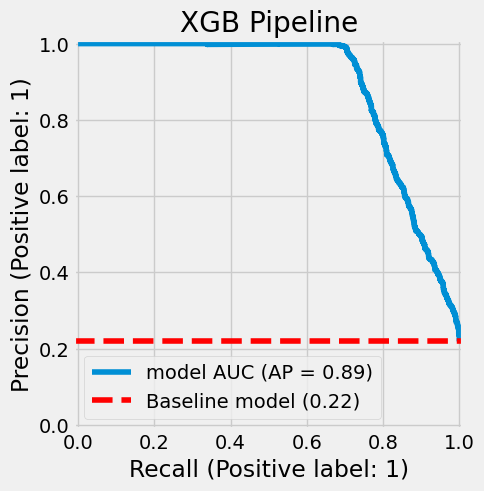

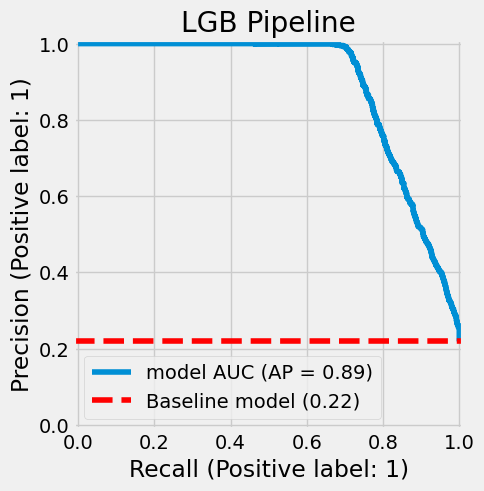

CPU times: user 2.66 s, sys: 12.7 ms, total: 2.67 s
Wall time: 3.54 s


In [96]:
%%time
def funct_pr(be,X_test,y_test,title):
    PrecisionRecallDisplay.from_estimator(be, X_test, y_test, name='model AUC')
    baseline = y_test.sum() / len(y_test)
    plt.axhline(baseline, ls='--', color='r', label=f'Baseline model ({round(baseline,2)})')
    plt.title(f"{title}")
    plt.legend(loc='best')
    plt.show()

funct_pr(pipe_xgb,X_test,y_test,"XGB Pipeline")
funct_pr(pipe_lgb,X_test,y_test,"LGB Pipeline")

Plotando a Curva ROC e calculando a AUC:
A métrica AUC-ROC nos ajuda a determinar e compreender a capacidade de um modelo em distinguir as classes. O critério de avaliação é: quanto maior a AUC, melhor o modelo.

A curva ROC representa a taxa de verdadeiros positivos em relação à taxa de falsos positivos, destacando assim a sensibilidade do modelo de classificação.

A AUC de um classificador é igual à probabilidade de que o classificador ranqueie um exemplo positivo escolhido aleatoriamente acima de um exemplo negativo escolhido aleatoriamente. A Área Sob a Curva (AUC) representa a capacidade de um classificador de distinguir entre classes e é usada como um resumo da curva ROC. Quanto maior a AUC, presume-se que melhor é o desempenho do modelo em diferenciar as classes positiva e negativa.

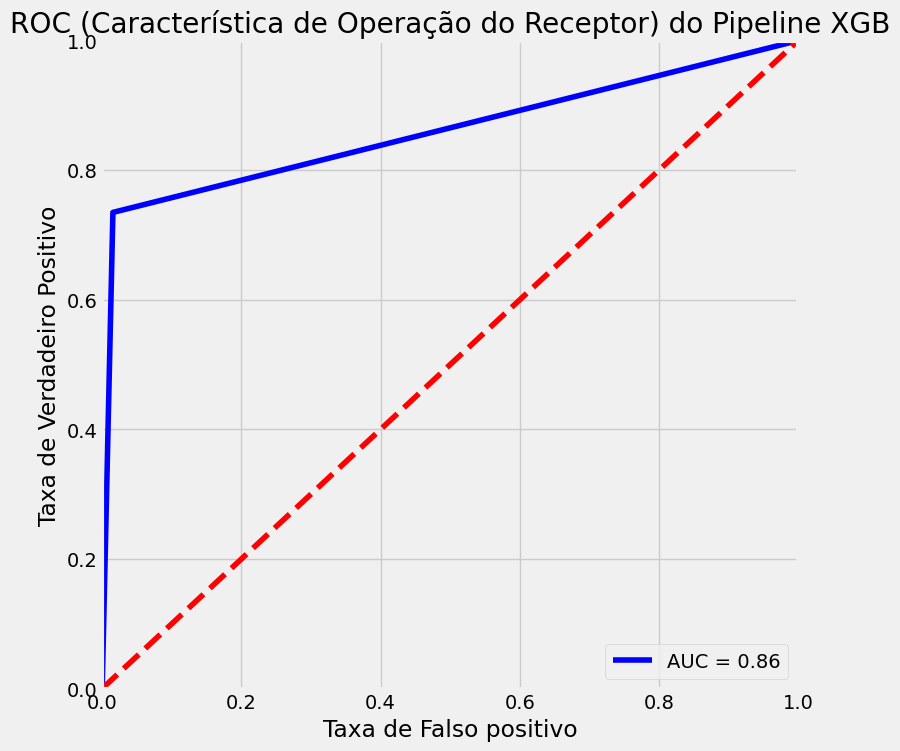

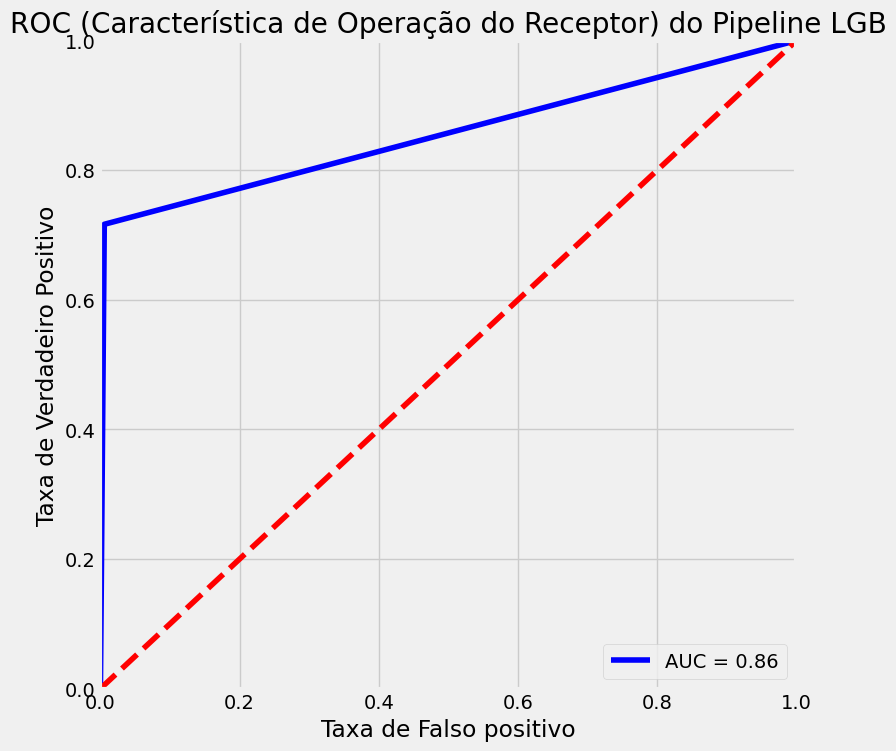

In [98]:
def funct_roc(y_test,preds,title):
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    # method I: plt
    plt.figure(figsize=(8,8))
    plt.title(f'ROC (Característica de Operação do Receptor) do {title}')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.xlabel('Taxa de Falso positivo')
    plt.show()

funct_roc(y_test,preds_xgb,"Pipeline XGB")
funct_roc(y_test,preds_lgb,"Pipeline LGB")

**Observação Importante:**

Geralmente, a utilidade das curvas ROC e das curvas Precisão-Revocação (Precision-Recall) dependerá da classe alvo:

As curvas ROC devem ser usadas quando há aproximadamente números iguais de observações para cada classe.

As curvas Precisão-Revocação devem ser usadas quando há um desequilíbrio moderado a grande entre as classes.

Cálculo do MCC:
O coeficiente de correlação de Matthews (MCC) é uma métrica que podemos usar para avaliar o desempenho de um modelo de classificação.

Ele é calculado como:

MCC = (TP * TN - FP * FN) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

Essa métrica é particularmente útil quando as duas classes estão desbalanceadas.

O valor do MCC varia de -1 a 1, onde:

-1 indica discordância total entre as classes previstas e as classes reais

0 é sinônimo de previsão completamente aleatória

1 indica concordância total entre as classes previstas e as classes reais

In [99]:
print(f"O MCC do Pipeline XGB é:{matthews_corrcoef(y_test, preds_xgb)}")
print(f"O MCC do Pipeline LGB é:{matthews_corrcoef(y_test, preds_lgb)}")

O MCC do Pipeline XGB é:0.7867061017718316
O MCC do Pipeline LGB é:0.7996047829354211


---
# 4. Escolhendo o melhor pipeline

Já que o Pipeline LGB deu o melhor resultado considerando acuracidade, esse será o pipeline escolhido.

In [103]:
# Salvando o melhor pipeline (LGBMClassifier)
filename = 'best_lgbm_pipeline.pkl'
pickle.dump(pipe_lgb, open(filename, 'wb'))

print(f"O melhor pipeline (LGBMClassifier) foi salvo como '{filename}'")

O melhor pipeline (LGBMClassifier) foi salvo como 'best_lgbm_pipeline.pkl'
